In [2]:
# Load libraries
import numpy as np
import pandas as pd
from numpy import arange
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

Importing the necessary libraries that will be used for classfication.
## Problem Definition
Given the dataset that contained collected data about the delays caused by incidents that accoured on various road routes, by various vehicles, at different dates and times and vehicles. The minimimum gap of time was also collected.
The aim of this machine learning project was to determine the minimum delay time as a result of the incident.
The problem therefore is a regression problem and not classification one.
We will use regression based algorithms.

### Import the Dataset

In [23]:
#importing all the tables
st14 = pd.read_excel(r'C:\Users\user\Desktop\Writing\Bon\streetcarml\ttc-streetcar-delay-data-2014.xlsx')
st15 = pd.read_excel(r'C:\Users\user\Desktop\Writing\Bon\streetcarml\ttc-streetcar-delay-data-2015.xlsx')
st16 = pd.read_excel(r'C:\Users\user\Desktop\Writing\Bon\streetcarml\ttc-streetcar-delay-data-2016.xlsx')
st17 = pd.read_excel(r'C:\Users\user\Desktop\Writing\Bon\streetcarml\ttc-streetcar-delay-data-2017.xlsx')
st18 = pd.read_excel(r'C:\Users\user\Desktop\Writing\Bon\streetcarml\ttc-streetcar-delay-data-20181.xlsx')
st19 = pd.read_excel(r'C:\Users\user\Desktop\Writing\Bon\streetcarml\ttc-streetcar-delay-data-2019.xlsx')
st20 = pd.read_excel(r'C:\Users\user\Desktop\Writing\Bon\streetcarml\ttc-streetcar-delay-data-2020.xlsx')
frames = [st14,st15,st16,st17,st18,st19,st20]
df = pd.concat(frames)

### I have limited RAM 12 gb only, running the whole dataset would have consumed a lot of time probablly half a day,
## i have opted to use 2014 data only
## Uncomment the above code to run the whole dataset
# also, the data from the excel files, i combined it on a yearly basis, i have included the restructured data files

In [4]:
#Import data
#df = pd.read_excel(r'C:\Users\user\Desktop\Writing\Bon\streetcarml\ttc-streetcar-delay-data-2014.xlsx')

### Peek at the data
Before making any changes to the data, inspect the various columns.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69955 entries, 0 to 4277
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Report Date  69541 non-null  datetime64[ns]
 1   Route        69541 non-null  float64       
 2   Time         69531 non-null  object        
 3   Day          69542 non-null  object        
 4   Location     69332 non-null  object        
 5   Incident     69541 non-null  object        
 6   Min Delay    66015 non-null  float64       
 7   Min Gap      65982 non-null  float64       
 8   Direction    69257 non-null  object        
 9   Vehicle      65880 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(5)
memory usage: 5.9+ MB


There are white spaces between the columns, which will make it hard during referencing hence the need to replace the white spaces with underscores

In [25]:
#Remove white spaces from column
df.columns = df.columns.str.replace(' ', '_')

### Feature Generation
From the report date we can generate features such as month, date, year features. From the date one can determine which semester of the year incidents were occurring. From date one can generate if the day was a weekend or not. Another fetaure generated from the date feature includes the quarter of year.

In [26]:
## Generate new features from report date
df['month'] = df['Report_Date'].dt.month
df['day_no'] = df['Report_Date'].dt.day #day of month
df['year'] = df['Report_Date'].dt.year
df['quarter'] = df['Report_Date'].dt.quarter
df['dayofweek'] = df['Report_Date'].dt.dayofweek
df['semester'] = np.where(df.quarter.isin([1,2]),1,2)
df['is_weekend'] = np.where(df['Day'].isin(['Sunday','Saturday']),1,0)

From the time variable we can obtain the hour feature.

In [27]:
from datetime import datetime
df['Time'] = pd.to_datetime(df['Time'],format= '%H:%M:%S' ).dt.time

In [28]:
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S' ).apply(pd.Timestamp)

In [29]:
#extract hour and minute features
df['hour'] = df['Time'].dt.hour

### Dropping the unnecessary variables

In [30]:
#delete the report_date feature
df = df.drop(['Report_Date'], axis = 1)

In [31]:
#Drop day and time feature, not useful now
df = df.drop(['Time'], axis = 1)
#Dropped Day column extracted day no from date
df = df.drop(['Day'], axis = 1)
#Drop vehicle column too many class variables
df = df.drop(['Vehicle'], axis = 1)
##Drop null values
df = df.dropna()

### Exploratory Data Analysis

In [32]:
df_num = df[['Min_Delay', 'Min_Gap']]
df_num.describe()

,Min_Delay,Min_Gap
count,65521.000000,65521.000000
mean,12.815845,18.366035
std,31.982086,35.112674
min,0.000000,0.000000
25%,5.000000,9.000000
50%,6.000000,12.000000
75%,11.000000,20.000000
max,1400.000000,4216.000000


Getting a summary statistic of the actual  numeric variables

In [33]:
## Getting correlation  between variables
df.corr(method = "pearson")

,Route,Min_Delay,Min_Gap,month,day_no,year,quarter,dayofweek,semester,is_weekend,hour
Route,1.000000,-0.027168,-0.056931,-0.009774,0.005892,-0.014560,-0.007088,-0.040802,-0.008656,-0.051103,0.154613
Min_Delay,-0.027168,1.000000,0.809025,0.006612,-0.002959,-0.001662,0.006011,0.030445,0.003958,0.033957,0.017328
Min_Gap,-0.056931,0.809025,1.000000,0.009986,-0.002591,0.008630,0.009370,0.038187,0.011591,0.044941,0.013383
month,-0.009774,0.006612,0.009986,1.000000,0.025977,-0.213009,0.971402,0.005216,0.869686,-0.000508,0.015383
day_no,0.005892,-0.002959,-0.002591,0.025977,1.000000,0.017103,0.026845,-0.004779,0.022993,-0.002547,0.011229
year,-0.014560,-0.001662,0.008630,-0.213009,0.017103,1.000000,-0.196861,0.026239,-0.135449,0.044743,0.019069
quarter,-0.007088,0.006011,0.009370,0.971402,0.026845,-0.196861,1.000000,-0.000627,0.896539,-0.002112,0.017688
dayofweek,-0.040802,0.030445,0.038187,0.005216,-0.004779,0.026239,-0.000627,1.000000,0.002591,0.750896,0.038431
semester,-0.008656,0.003958,0.011591,0.869686,0.022993,-0.135449,0.896539,0.002591,1.000000,0.004321,0.014851
is_weekend,-0.051103,0.033957,0.044941,-0.000508,-0.002547,0.044743,-0.002112,0.750896,0.004321,1.000000,0.046733


The correlation mostly range between -1 and 1 for variables in relation to the Min Daly time. MIn Gap is the one variable that has a strong corrlation with the minimum delay time.

## Visualizations

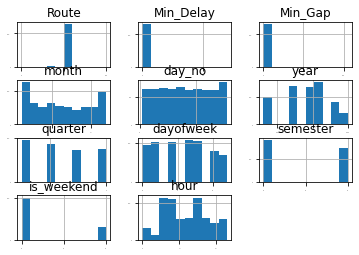

In [34]:
# histograms
df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
pyplot.show()

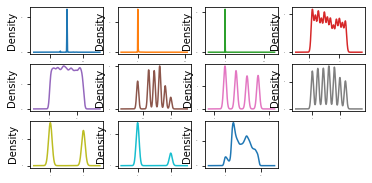

In [35]:
# density
df.plot(kind='density', subplots=True, layout=(4,4), sharex=False, legend=False,
fontsize=1)
pyplot.show()


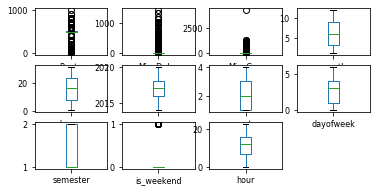

In [36]:
# box and whisker plots
df.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False,
fontsize=8)
pyplot.show()

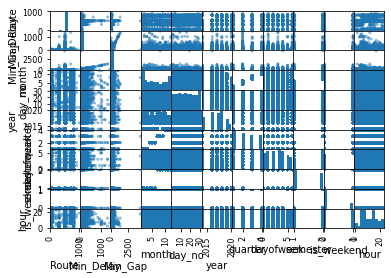

In [37]:
# scatter plot matrix
from pandas.plotting import scatter_matrix
scatter_matrix(df)
pyplot.show()

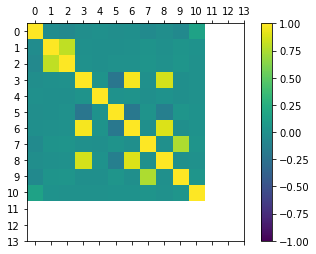

In [38]:
# correlation matrix
fig = pyplot.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax)
ticks = np.arange(0,14,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
pyplot.show()

    ### Function To Clean and Prepare Data
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    Perform to obtain the correct X and y objects
    This function cleans df using the following steps to produce X and y:
    1. Select the numeric variables in the dataset
    2. Imputes the mean to fill null values for numeric variables
    3. Select the categorical variables
    4. Creates dummy columns for the categorical variables
    5. Create X as all the columns that are not the Price column
    6. Create y as the Price column

    '''

In [39]:
#Function for data cleaning
def clean_data(df):
   
  
    num_vars= df.select_dtypes(include=['int','float']).copy().columns
    scaler = MinMaxScaler()
    df[["Min_Delay", "Min_Gap"]] = scaler.fit_transform(df[["Min_Delay", "Min_Gap"]])

   
    for var in num_vars:
        df[var].fillna((df[var].mean()), inplace=True)

   
    cat_vars = df.select_dtypes(include=['object']).copy().columns

   
    for var in cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
   
    X = df.drop(columns=["Min_Delay"], axis=1)
    y = df['Min_Delay']
    
    return X, y


Generate the dataframe into featurs and labels. Lables oftern are represented as y

In [40]:
X, y = clean_data(df)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=42) 

In [42]:
# Test options and evaluation metric
num_folds = 10
seed = 7
scoring = 'neg_mean_squared_error'

In [ ]:
# Spot-Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('xgb', XGBRegressor()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


In [ ]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

##Estimator Failed for Xgb
Linear regression is the best model because it has the least Root Mean Squared error

In [ ]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',
LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO',
Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN',
ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',
KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',
DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

From the RMSE, the best model suggested is Linear Regression Model. However, the disparity between the values, the model is too good hence cannot be trusted. We can therefore focus on the other models. The best model is Rf ,after CART models,which is an ensemble method. Suggesting that the ensemble method would improve better perfomance. 

In [ ]:
# I did not run this ensemble to improve time  because of the time costraint
# use ensemble methods 
# ensembles
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor())])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor())])))

results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)



In [ ]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [ ]:
## Determine which is the best model after the ensemble method and train the model, the AB model performs best(AB model)

In [ ]:
## Linear Regression is still the best model, by a huge difference so prepare the model
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = AdaBoostRegressor()
model.fit(rescaledX, y_train)

In [ ]:
# transform the validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model.predict(rescaledValidationX)
print(mean_squared_error(y_test, predictions))

In [ ]:
## Residual Plot of Training data vs Test data
import matplotlib.pyplot as plt
plt.scatter(y_test, predictions)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, predictions, 1))(np.unique(y_test)))